In [48]:
import json
import os
import numpy
import pandas
import sys
import logging
import importlib

from datetime import date
from os import path
from dotenv import load_dotenv

sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

from bespoke.inventory.analysis.shared import download_util
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util
from bespoke.inventory.analysis import inventory_cogs_util as cogs_util
from bespoke.inventory.analysis import inventory_summary_util
from bespoke.inventory.analysis import stale_inventory_util
from bespoke.inventory.analysis.shared.inventory_types import (
  AnalysisSummaryDict
)

load_dotenv(verbose=True)
engine = download_util.get_bigquery_engine('bigquery://bespoke-financial/ProdMetrcData')

logging.basicConfig(format='%(asctime)s [%(levelname)s] - %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

def _reload_libs():
    importlib.reload(util)
    importlib.reload(valuations_util)
    importlib.reload(download_util)
    importlib.reload(stale_inventory_util)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
COMPANY_NAME = 'MPW'
COMPANY_IDENTIFIER = 'MPW'
LICENSE_NUMBERS = [] # ['MR281525'] # Manufacturer FYI - 'MP281397'
TRANSFER_PACKAGES_START_DATE = '2019-01-01'
SALES_TRANSACTIONS_START_DATE = '2019-01-01'
ANALYSIS_PARAMS = {
    'sold_threshold': 1.0,
    'find_parent_child_relationships': False,
    'use_prices_to_fill_missing_incoming': False,
    'external_pricing_data_config': {
        'category_to_fixed_prices': {
            'Buds': {
                'grams': 10.0
            },
            'Infused (edible)': {
                'each': 4.0
            },
            'Infused (non-edible)': {
                'each': 3.0
            },
            'Vape Product': {
                'each': 3.0
            },
            'Concentrate (Bulk)': {
                'grams': 6.0
            },
            'Concentrate': {
                'grams': 7.0
            },
            'Raw Pre-Rolls': {
                'grams': 7.0,
                'pounds': 80.0
            },
            'Shake/Trim (by strain)': {
                'grams': 8.0
            }
        }
    },
    'use_margin_estimate_config': False,
    'margin_estimate_config': {
        'category_to_margin_estimate': {
            'Buds': 0.4267,
            'Infused (edible)': 0.4953,
            'Infused (non-edible)': 0.4183,
            'Vape Product': 0.43,
            'Concentrate (Bulk)': 0.46,
            'Concentrate': 0.46,
            'Raw Pre-Rolls': 0.485,
            'Shake/Trim (by strain)': 0.4267
        }
    },
    'cogs_analysis_params': {
        'readjust_profit_threshold': 0.90, # 0.9
        'readjust_type': 'adjust' # adjust, remove
    }
}
TODAY_DATE = date.today()
print('Today is {}'.format(TODAY_DATE))

ctx = download_util.AnalysisContext(
    output_root_dir=f'out/{COMPANY_NAME}',
    read_params={
        'use_cached_dataframes': False
    },
    write_params={
        'save_download_dataframes': False
    }
)
ctx.mkdir('reports')
ctx.mkdir('download')
with open(ctx.get_output_path('log.txt'), 'w') as f:
    f.write('')

Today is 2021-11-23


In [50]:
# Download packages, sales transactions, incoming / outgoing tranfers
q = download_util.Query(
    inventory_dates=[],
    transfer_packages_start_date=TRANSFER_PACKAGES_START_DATE,
    sales_transactions_start_date=SALES_TRANSACTIONS_START_DATE,
    company_identifier=COMPANY_IDENTIFIER,
    company_name=COMPANY_NAME,
    license_numbers=LICENSE_NUMBERS
)

all_dataframes_dict = download_util.get_dataframes_for_analysis(
    q, ctx, engine, dry_run=False)

In [51]:
_reload_libs()

q.inventory_dates = download_util.get_inventory_dates(
    all_dataframes_dict, TODAY_DATE)
d = util.Download()
sql_helper = util.BigQuerySQLHelper(ctx, engine)
d.download_dataframes(
    all_dataframes_dict=all_dataframes_dict,
    sql_helper=sql_helper
)

In [52]:
_reload_libs()

id_to_history = util.get_histories(d, ANALYSIS_PARAMS)
util.print_counts(ctx, id_to_history)
counts_analysis_dict = util.create_inventory_xlsx(
    d, ctx, id_to_history, q, params=ANALYSIS_PARAMS)

Only outgoing: 0
Only incoming: 1894
Sold packages missing incoming_pkg: 1002 (6.84% of packages)
Incoming packages missing price 108 (0.79% of incoming packages)
In and out: 4
In and sold at least once 11713
In and sold many times 10055

 Num parent packages: 0
 num matched child packages: 0
Total pkgs: 14659


11/23/2021 10:18:49 [INFO] - Wrote result to out/MPW/reports/MPW_computed_inventory_by_month.xls
11/23/2021 10:18:53 [INFO] - Wrote result to out/MPW/reports/MPW_current_inventory.xls




Excluded 1284 / 14659 packages from consideration (8.76%)
  OUT_OF_ORDER_DATES: 129 times
  INCOMING_MISSING_PRICE: 105 times
  MISSING_INCOMING: 1050 times


In [21]:
_reload_libs()

   
computed_resp = util.compute_inventory_across_dates(
    d, q.inventory_dates, ANALYSIS_PARAMS, using_nb=True
)

today_date_str = TODAY_DATE.strftime('%m/%d/%Y')
#INVENTORY_DATES = [today_date_str]
compare_inventory_res = util.compare_computed_vs_actual_inventory(
    ctx=ctx,
    computed=computed_resp['date_to_computed_inventory_dataframe'][today_date_str],
    actual=d.inventory_packages_dataframe,
    compare_options={
        'num_errors_to_show': 10,
        'accept_computed_when_sold_out': True
    }
)


11/20/2021 13:11:37 [INFO] - On 06/30/2020 # packages in inventory: 49, valuation cost: 83699.64
11/20/2021 13:11:38 [INFO] - On 07/31/2020 # packages in inventory: 81, valuation cost: 87629.72
11/20/2021 13:11:38 [INFO] - On 08/31/2020 # packages in inventory: 74, valuation cost: 38127.67
11/20/2021 13:11:38 [INFO] - On 09/30/2020 # packages in inventory: 73, valuation cost: 21499.65
11/20/2021 13:11:39 [INFO] - On 10/31/2020 # packages in inventory: 80, valuation cost: 16601.2
11/20/2021 13:11:39 [INFO] - On 11/30/2020 # packages in inventory: 85, valuation cost: 41547.72
11/20/2021 13:11:40 [INFO] - On 12/31/2020 # packages in inventory: 71, valuation cost: 45546.44
11/20/2021 13:11:40 [INFO] - On 01/31/2021 # packages in inventory: 105, valuation cost: 60836.04
11/20/2021 13:11:40 [INFO] - On 02/28/2021 # packages in inventory: 125, valuation cost: 50384.83
11/20/2021 13:11:41 [INFO] - On 03/31/2021 # packages in inventory: 136, valuation cost: 40689.75
11/20/2021 13:11:41 [INFO] -


Pct of # inventory matching: 99.11% (223 / 225)
Accuracy of quantities for matching packages: 86.43%
Pct of # inventory packages over-estimated: 0.00%
Pct of # quantity over-estimated: 0.00%
Avg quantity delta of matching packages: 8.54
Avg quantity of matching packages: 62.94

Num matching packages: 223
Num actual packages not computed: 2
  but computed at some point: 0, e.g., 0.00% of non-computed packages
  avg quantity from actual packages 0.00
Num computed packages not in actual: 0
  but in actual inventory at some point: 0

Computed has these extra package IDs; first 10

Computed is missing these package IDs; first 10
2981217: actual quantity 200.0 (Grams) of Buds
2842719: actual quantity 169.0 (Grams) of Raw Pre-Rolls

Largest delta in quantities; first 10
Delta 1005.00 for package_id 2484577
Delta 862.70 for package_id 2550280
Delta 10.00 for package_id 767702
Delta 10.00 for package_id 767807
Delta 7.00 for package_id 2603622
Delta 3.50 for package_id 2474547
Delta 1.00 for p

In [13]:
_reload_libs()

# Do the COGS summary too
#  debug_package_id='1791802',
#  debug_profit_threshold=0.9

cogs_summary = cogs_util.create_cogs_summary(
    d, ctx, id_to_history, ANALYSIS_PARAMS, 
)

cogs_util.write_cogs_xlsx(
    ctx=ctx,
    topdown_cogs_rows=cogs_summary['topdown_cogs_rows'], 
    bottoms_up_cogs_rows=cogs_summary['bottomsup_cogs_rows'],
    company_name=COMPANY_NAME
)

analysis_summary = AnalysisSummaryDict(
    company_name=q.company_name,
    company_identifier=q.company_identifier,
    analysis_params=ANALYSIS_PARAMS,
    counts_analysis=counts_analysis_dict,
    compare_inventory_results=compare_inventory_res,
    cogs_summary=cogs_summary
)
inventory_summary_util.write_excel_for_summaries([analysis_summary])

11/20/2021 12:53:54 [INFO] - Wrote result to out/reports/BBF_cogs_summary.xls
11/20/2021 12:53:54 [INFO] - Wrote result to out/BBF_analysis_summary.xls


In [53]:
# Stale inventory

_reload_libs()
stale_inventory_util.compute_stale_inventory(d, ctx)

11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Capsule (weight - each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Capsule (weight - each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Capsule (weight - each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Capsule (weight - each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Seeds (each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Seeds (each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Seeds (each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Seeds (each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Seeds (each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Seeds (each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for product category Seeds (each)
11/23/2021 10:19:02 [INFO] - Unknown shelf life for pr

Got an invalid quantity Product Vape Cartridge (weight - each) -1.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting -1.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected package type ImmaturePlant Clone - Cutting 0.0
Got an unexpected pac

/Users/davidlluncor/GitHub/platform/services/api-server/src/bespoke/inventory/analysis/stale_inventory_util.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (d.incoming_transfer_packages_dataframe['shipper_wholesale_price'] != 0.01) | (d.incoming_transfer_packages_dataframe['shipped_quantity'] != 1)



# packages stale: 3800 (26.696641843473373%)
# packages unknown: 72 (0.5058311086131797%)
# packages fresh: 10362 (72.79752704791345%)
# packages total: 14234

# units stale: 6086.040000000001 (10.159808090065454%)
# units unknown: 178.0 (0.29714655835841547%)
# units fresh: 53639.06000000001 (89.54304535157614%)
# units total: 59903.10000000001


KeyError: "['shipper_facility', 'sales_month', 'sales_date'] not in index"

Plotting sales revenue vs cost-based inventory valuation for dates: ['06/30/2020', '07/31/2020', '08/31/2020', '09/30/2020', '10/31/2020', '11/30/2020', '12/31/2020', '01/31/2021', '02/28/2021', '03/31/2021', '04/30/2021', '05/31/2021', '06/30/2021', '07/31/2021', '08/31/2021', '09/30/2021', '10/31/2021', '11/15/2021']


11/15/2021 15:18:30 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11/15/2021 15:18:30 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11/15/2021 15:18:30 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11/15/2021 15:18:30 [INFO] - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


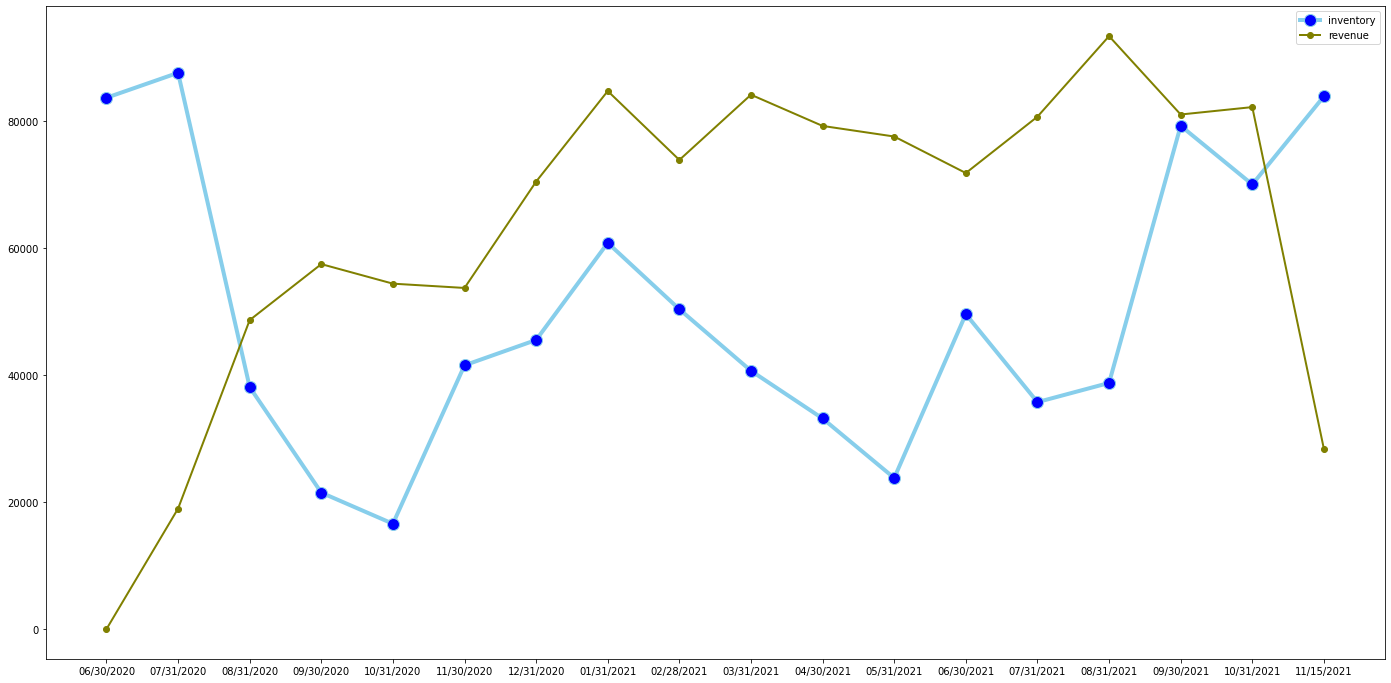

In [27]:
_reload_libs()

print(f'Plotting sales revenue vs cost-based inventory valuation for dates: {q.inventory_dates}')
valuations_util.plot_inventory_and_revenue(
    q=q,
    sales_receipts_dataframe=d.sales_receipts_dataframe,
    inventory_valuations=computed_resp['inventory_valuations']
)

In [ ]:
#### DEBUG
util.run_orphan_analysis(d, ctx, id_to_history)

In [96]:
# For debugging individual package histories
_reload_libs()

PACKAGE_IDS = [
  '767702'
]

util.analyze_specific_package_histories(
    d, PACKAGE_IDS, params=ANALYSIS_PARAMS)

11/16/2021 11:05:32 [INFO] - 
Package 767702 arrived on 07/14/2020 with quantity 47.0 and price $30.0.
Package 767702 sold on 08/15/2020 1.0 (Each) for $65.0
Package 767702 sold on 12/03/2020 1.0 (Each) for $60.0
Package 767702 sold on 12/07/2020 1.0 (Each) for $60.0
Package 767702 sold on 01/02/2021 3.0 (Each) for $180.0
Package 767702 sold on 01/04/2021 1.0 (Each) for $60.0
Package 767702 sold on 01/21/2021 2.0 (Each) for $120.0
Package 767702 sold on 01/28/2021 1.0 (Each) for $60.0
Package 767702 sold on 02/28/2021 1.0 (Each) for $60.0
Package 767702 sold on 03/16/2021 1.0 (Each) for $55.0
Package 767702 sold on 03/22/2021 1.0 (Each) for $55.0
Package 767702 sold on 04/03/2021 1.0 (Each) for $55.0
Package 767702 sold on 05/29/2021 1.0 (Each) for $55.0
Package 767702 sold on 06/11/2021 1.0 (Each) for $55.0
Package 767702 sold on 06/23/2021 1.0 (Each) for $50.0
Package 767702 sold on 07/06/2021 1.0 (Each) for $45.0
Package 767702 sold on 07/11/2021 1.0 (Each) for $45.0
Package 767702 

DEBUGGING PACKAGE_ID=767702
Matching active metrc_package:
{'license_number': 'MR281525', 'package_id': '767702', 'package_label': '1A40A01000010CD000010718', 'type': 'active', 'packaged_date': datetime.date(2020, 7, 14), 'last_modified_at': Timestamp('2021-11-16 01:02:42+0000', tz='UTC'), 'package_type': 'Product', 'product_name': 'M00000249805: Vape Rythm Heal PAX Pod Otto 1:1 Concentrate', 'product_category_name': 'Vape Product', 'quantity': 5.0, 'unit_of_measure': 'Each', 'item_id': 249805, 'item_product_category_type': 'Concentrate', 'production_batch_number': '', 'source_production_batch_numbers': '', 'source_harvest_names': '', 'is_testing_sample': False, 'is_trade_sample': False, 'is_on_hold': False, 'archived_date': None, 'finished_date': None}

INCOMING
{'delivery_type': 'INCOMING_FROM_VENDOR', 'license_number': 'MR281525', 'manifest_number': '0000170521', 'created_date': datetime.date(2020, 7, 14), 'received_datetime': datetime.datetime(2020, 7, 14, 23, 32, 25, tzinfo=<UTC>)